# Z-Mass peak with Spark
With the basics of an analysis under our belt, let's look at di-muon events from 2016 CMS data.

For sake of berevity, we'll skip a lot of steps that would be necessary for a "real" result. As we walk through this simplified analysis, note how and where these extra corrections could be applied.

Like before, we need to begin our Spark session. You shouldn't need to change any of the following values

In [1]:
# Start up Spark (only needs to be done once)
import os
import pyspark.sql
import sys
session = pyspark.sql.SparkSession.builder \
    .appName("pyspark-zpeak") \
    .config('spark.jars.packages', 'org.diana-hep:spark-root_2.11:0.1.16,org.diana-hep:histogrammar-sparksql_2.11:1.0.4') \
    .getOrCreate()
sc = session.sparkContext
sqlContext = session

# ROOT into DataFrame
The Spark-ROOT project lets us load ROOT files directly into dataframes. Execute the following to load a standard analysis-level ntuple into ROOT then print its schema. You should see familiar branches

```python
import os
testPath = "file://%s/../root/test-tuple.root" % os.getcwd()
df = spark.read \
            .format("org.dianahep.sparkroot") \
            .load(testPath)
df.printSchema()
```

In [3]:
import os
testPath = "file://%s/../root/test-tuple.root" % os.getcwd()
df = session.read \
            .format("org.dianahep.sparkroot") \
            .load(testPath)
df.printSchema()

root
 |-- Trigger_decision: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Trigger_prescale: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_energy: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_tight: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- Muon_loose: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- Muon_medium: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- Muon_soft: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-

# Load the 2016 data
The following snippet of code reads a list of input datasets from a JSON file and adds additional columns with the cross-sections and processing efficiencies.

In [5]:
import json
from pyspark.sql.functions import lit

dataDFList = []
mcDFList = []

sys.stdout.write("\nLoading DataFrames ")
fileInputs = json.loads(open("input-hats.json", "r").read())

for category, subcategory, path, xsec, efficiency in fileInputs: 
    if category in ("Category", "DISABLED"):
        continue
    
    dsPath = "hdfs://cmshdfs/tmp/store/group/ra2tau/" + path + "/"
    tempDF = sqlContext.read.load(dsPath) \
                    .withColumn("Category", lit(category)) \
                    .withColumn("SubCategory", lit(subcategory)) \
                    .withColumn("xsec", lit(xsec)) \
                    .withColumn("eff", lit(efficiency))

    if xsec == "DATA":
        dataDFList.append([tempDF, category, subcategory, xsec, efficiency])
    else:
        mcDFList.append([tempDF, category, subcategory, xsec, efficiency])

    sys.stdout.write('.')
print("done")


Loading DataFrames .......................done


# Combine DataFrames
The previous step yields a DataFrame per-dataset, which can be unwieldy to manage. Spark's `union` function concatenates two DataFrames together. Let's loop over everything and make a DataFrame for MC and another for data.

In [12]:
# Monte-Carlo
if mcDFList:
    mcDF = mcDFList[0][0]
    for x in mcDFList[1:]:
        mcDF = mcDF.union(x[0])
    print("MC Partitions:  %d" % mcDF.rdd.getNumPartitions())

# Data
if dataDFList:
    dataDF = dataDFList[0][0]
    for x in dataDFList[1:]:
        dataDF = dataDF.union(x[0])
    print("Data Partitions: %d" %dataDF.rdd.getNumPartitions())

MC Partitions:  7592
Data Partitions: 10525


# Drop unneeded columns
Spark is intelligent about how it executes queries, so any unneeded columns are simply not read (similar to how ROOT handles reading branches). That being said, these ntuples have 300 columns, so functions like `printSchema()` and `show()` are unintelligible. Execute the following cell to remove branches that won't be useful for this tutorial.

In [13]:
reqCol = ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_energy',
          'Muon_charge', 'Muon_loose', 'Muon_tight', 'Muon_isGlobal',
          'Jet_pt', 'Jet_eta', 'Jet_phi', 'Jet_energy',
          'Met_type1PF_pt','Met_type1PF_px','Met_type1PF_py',
          'Met_type1PF_pz','Met_type1PF_phi',
          'eff', 'xsec', 'Category', 'SubCategory']
trimMCDF = mcDF.select(*reqCol)
trimDataDF = dataDF.select(*reqCol)

# Weigh our MC events
Like usual, we'll need to weigh each MC event to take into the theoretical cross-section and processing efficiency. Let's add an additional column for the `xsec * efficiency * lumi` portion of that scaling.

In [14]:
processedLumiPB = 35900
mcWeight = (trimMCDF['xsec'] * trimMCDF['eff'] * processedLumiPB)
weightedMCDF = trimMCDF.withColumn("weight", 1/mcWeight)
weightedDataDF = trimDataDF.withColumn("weight", lit(1.0))

# Data weight?
You probably noticed in the previous slide that we added a weight column for data as well.

We would like to combine our data and MC DataFrames into a single DF, but DFs have the restriction that each row must have the same columns as every other row. In the next step, we'll combine the data and MC into one combined DF, so data also needs a weight.

In [15]:
# Combine Data and MC frames
trimDF = weightedMCDF.union(weightedDataDF)

Similar to doing a ROOT-based analysis, it is often helpful to split the transforms into two parts:

1. A rarely changing part with either time consuming calculations or steps which drop many events
2. A part under more active development

Check-pointing after a strong cut (like the trigger) is relatively easy and is a huge boost to the time it takes to load the data for your analyses

# Transform our DataFrame
At this point, we've loaded our data into Spark, and we're ready to begin applying object and event selections. We'll do these selections by applying a transformation to our input data to get a new DF. Then, we repeat the process by applying a transformation to this new DF to get another DF (and so on).

# DataFrames are functional
Producing results by chaining several idempotent transformations together on immutable objects is known as "functional" programming. There are several benefits to this technique:

1. Easily-implemented lazy evaluation
2. Easier to (auto-) parallelize
3. "Where" an object came from is well-defined

# Our input
Let's take a moment to look our input DF. First, let's look at the schema

In [16]:
trimDF.printSchema()

root
 |-- Muon_pt: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_energy: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_loose: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- Muon_tight: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- Muon_isGlobal: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- Jet_pt: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Jet_eta: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Jet_phi: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Jet_energy: array (n

In the next cell, let's look at the muon columns of our first row with a `select()` and a `show()`
```python
trimDF.select("Muon_pt", "Muon_eta", "Muon_phi").show(1, truncate = False)
```
Spark implements this simple command by
1. Executing `select()` against trimDF to produce a new (unnamed) DF
2. Executing `show()` against this new DF

In [17]:
trimDF.select("Muon_pt", "Muon_eta", "Muon_phi").show(1, truncate = False)

+-------+--------+--------+
|Muon_pt|Muon_eta|Muon_phi|
+-------+--------+--------+
|[]     |[]      |[]      |
+-------+--------+--------+
only showing top 1 row



# Flatten our DataFrame
As you can see from the previous cell (and `printSchema()`), some columns have lists and aren't plain scalar values.

Since we're looking at di-muon events, let's replace the lists of muons with the properties of the two-highest pT muons in the event.

This logic would be very hard to write as a `where()` statement. Let's use a User Defined Function (UDF) instead.

# User Defined Function (UDF)
UDFs can be used for transformations that are more complex than can be expressed with `where()` and friends.

For each row in the input DF, Spark will call your UDF and pass in the columns you request. The return value is added as a new column in the output DF.

Unfortunately, Spark doesn't support having a single UDF fill multiple columns, so we have to cheat a bit and pack multiple values into a single column.

First, let's define a custom type for our return value

In [18]:
from pyspark.sql.types import *

schema = StructType([
    StructField("pass", BooleanType(), False),
    StructField("mu1_pt", FloatType(), False),
    StructField("mu2_pt", FloatType(), False),
    StructField("mu1_eta", FloatType(), False),
    StructField("mu2_eta", FloatType(), False),
    StructField("mu1_phi", FloatType(), False),
    StructField("mu2_phi", FloatType(), False),
    StructField("mu1_charge", FloatType(), False),
    StructField("mu2_charge", FloatType(), False),
])

Then we can define the function that Spark will use. This function can be written in several languages, but let's use Python. It's quite a bit slower than the alternatives, but is simple for our tutorial.

Our `muonTestFalse()` function accepts lists of muon pt, eta, phi, charge and the "loose" ID flag.

The logic in the loop is straightforward. Look through the muons lists to find exactly two candidates which match some properties.

The return value has the properties of the selected muons with an additional flag called "pass", which is true if the muons pass our event-wide selections.

In [19]:
muonTestFalse = (False, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
def muonTest(pt,eta,phi,charge,loose):
    """
    An absolutely unphysical dimuon selection function
    """
    passes = True
    if len(pt) < 2:
        return muonTestFalse
    
    leadingIdx = None
    trailingIdx = None
    for idx in range(len(pt)):
        if leadingIdx == None:
            if pt[idx] > 30 and abs(eta[idx]) < 2.1 and loose[idx]:
                leadingIdx = idx
        elif trailingIdx == None:
            if pt[idx] > 10 and abs(eta[idx]) < 2.1 and (loose[idx]):
                trailingIdx = idx
        else:
            if pt[idx] > 10 and abs(eta[idx]) < 2.1 and loose[idx]:
                return muonTestFalse
    
    if leadingIdx != None and trailingIdx != None:
        return (True, pt[leadingIdx], pt[trailingIdx],
                        eta[leadingIdx], eta[trailingIdx],
                        phi[leadingIdx], phi[trailingIdx],
                        charge[leadingIdx], charge[trailingIdx])
    else:
        return muonTestFalse

In [21]:
# Some example muons to test we get the right thing from our UDF
# This should pass
print (muonTest([52.707950592041016, 35.526939392089844],
                 [0.24396079778671265, -0.08245399594306946],
                 [-0.8336199522018433, 2.2777249813079834],
                 [1.0, -1.0],
                 [True, True]))
# This should fail
print (muonTest([52.707950592041016, 5.526939392089844],
                 [0.24396079778671265, -0.08245399594306946],
                 [-0.8336199522018433, 2.2777249813079834],
                 [1.0, -1.0],
                 [True, True]))

(True, 52.707950592041016, 35.526939392089844, 0.24396079778671265, -0.08245399594306946, -0.8336199522018433, 2.2777249813079834, 1.0, -1.0)
(False, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


# Apply the UDF
Now that we have the UDF and result type, let's tell Spark to produce an additional column with the results of the UDF.

In [22]:
# Convert the python function to a Spark UDF
from pyspark.sql.functions import udf
muonUDF = udf(muonTest, schema)
# Make a new column "flat" and fill it with the results of muonUDF
flatDF = trimDF.withColumn("flat", muonUDF("Muon_pt", 
                                           "Muon_eta",
                                           "Muon_phi",
                                           "Muon_charge",
                                           "Muon_loose"))

Use the cell below to inspect the new column we just made. Modify the `show()` statement we used a few cells before. It can be helpful to also pass `truncate = False` to `show()`

In [79]:
flatDF.select('flat').show(100, truncate=False)

+---------------------------------------------------------------------------------------+
|flat                                                                                   |
+---------------------------------------------------------------------------------------+
|[false, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                        |
|[true, 46.776653, 30.883327, 1.8596525, 0.5911593, -2.3878894, 1.0909842, -1.0, 1.0]   |
|[false, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                        |
|[false, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                        |
|[false, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                        |
|[false, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                        |
|[false, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                        |
|[false, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                        |
|[false, 0

# Filter with event-level cuts
The UDF interface allows us to fill a column, but it doesn't have the ability to throw away a row that failed certain conditions. Our UDF sets `flat.pass` to `False` for events that fail our cuts. We have to perform a second step to actually remove those events from the DataFrame.

Make a new DF named `muonPassDF` with an additional requirement that `pass` is true. Then, `show()` the result.

Tip: Since "flat" is a structure, the "pass" member is called flat.pass

In [48]:
muonPassDF = flatDF.where(flatDF["flat.pass"] == True)

In [78]:
muonPassDF.select('flat').show(5, truncate=False)

+--------------------------------------------------------------------------------------+
|flat                                                                                  |
+--------------------------------------------------------------------------------------+
|[true, 46.776653, 30.883327, 1.8596525, 0.5911593, -2.3878894, 1.0909842, -1.0, 1.0]  |
|[true, 41.229206, 20.373138, -1.6499293, 0.43716937, 2.031217, -1.1967071, -1.0, 1.0] |
|[true, 42.480106, 42.45014, -1.392551, -0.46875775, 0.5535147, -2.7806356, -1.0, 1.0] |
|[true, 38.490536, 35.056725, 1.5400337, 0.98230094, -1.8349391, 1.2168431, 1.0, -1.0] |
|[true, 33.644318, 27.406054, 0.99794424, -0.7570846, -1.5671006, 1.7398627, -1.0, 1.0]|
+--------------------------------------------------------------------------------------+
only showing top 5 rows



# Caching
By default, Spark will use some portion of its RAM to cache DFs. You can also instruct Spark to cache both in RAM and to disk with `cache()`. This is useful for DFs who have very expensive transformations you don't want to recalculate.

In [55]:
# Explicit caching can take quite a bit of time, so let's skip it for now
# finalDF = muonPassDF.cache()

# Instead, let's just pass the finalDF straight through
finalDF = muonPassDF

# Your turn: Calculate the dimuon invariant mass
Using the UDF example before, add a column to `finalDF` with the invariant mass of the dimuon system

Tip: The relevant parts of ROOT's TLorentzVector is the following:
```c
void TLorentzVector::SetPtEtaPhiM(Double_t pt, Double_t eta, Double_t phi, Double_t m) {
    pt = TMath::Abs(pt);
    SetXYZM(pt*TMath::Cos(phi), pt*TMath::Sin(phi), pt*sinh(eta) ,m);
}
void TLorentzVector::SetXYZM(Double_t  x, Double_t  y, Double_t  z, Double_t m) {
    if ( m  >= 0 )
        SetXYZT( x, y, z, TMath::Sqrt(x*x+y*y+z*z+m*m) );
    else
        SetXYZT( x, y, z, TMath::Sqrt( TMath::Max((x*x+y*y+z*z-m*m), 0. ) ) );
}
inline void TLorentzVector::SetXYZT(Double_t  x, Double_t  y, Double_t  z, Double_t t) {
    fP.SetXYZ(x, y, z);
    SetT(t);
}
inline void TLorentzVector::SetT(Double_t a) {
    fE = a;
}
TLorentzVector TLorentzVector::operator + (const TLorentzVector & q) const {
    return TLorentzVector(fP+q.Vect(), fE+q.T());
}
```

In [82]:
import math
def dimuonmass(m1_pt,m2_pt,m1_eta,m2_eta,m1_phi,m2_phi):
    muon_mass = 0.1056
    
    m1_x = m1_pt*math.cos(m1_phi)
    m1_y = m1_pt*math.sin(m1_phi)
    m1_z = m1_pt*math.sinh(m1_eta)
    m1_t = math.sqrt(m1_x*m1_x + m1_y*m1_y + m1_z*m1_z + muon_mass*muon_mass)
    
    m2_x = m2_pt*math.cos(m2_phi)
    m2_y = m2_pt*math.sin(m2_phi)
    m2_z = m2_pt*math.sinh(m2_eta)
    m2_t = math.sqrt(m2_x*m2_x + m2_y*m2_y + m2_z*m2_z + muon_mass*muon_mass)
    
    dimu_x = m1_x + m2_x
    dimu_y = m1_y + m2_y
    dimu_z = m1_z + m2_z
    dimu_t = m1_t + m2_t
    
    dimu_mass = math.sqrt(dimu_t*dimu_t - dimu_x*dimu_x - dimu_y*dimu_y - dimu_z*dimu_z )
    
    return dimu_mass
    
dimuonUDF = udf(dimuonmass, FloatType())

finalDF = finalDF.withColumn("dimumass", dimuonUDF("flat.mu1_pt","flat.mu2_pt","flat.mu1_eta","flat.mu2_eta","flat.mu1_phi","flat.mu2_phi"))

finalDF.select('dimumass').show(5, truncate=False)

+---------+
|dimumass |
+---------+
|90.93492 |
|92.462715|
|93.79795 |
|76.2713  |
|85.50589 |
+---------+
only showing top 5 rows



# Finally: our requested plot
At this point, our DF has the data we need. Run the following snippet in the next cell to load Matplotlib and Histogrammar

```python
%matplotlib inline
import matplotlib.pyplot as plt
import histogrammar as hg
import histogrammar.sparksql
```

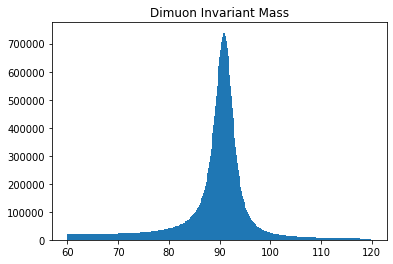

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
import histogrammar as hg
import histogrammar.sparksql

hg.sparksql.addMethods(finalDF)

h1 = finalDF.Bin(360, 60, 120, finalDF['dimumass'])
ax = h1.plot.matplotlib(name="Dimuon Invariant Mass")

# Your turn: Plot the dimuon invariant mass
Using what you learned in the first part, plot the dimuon invariant mass for the different Monte-Carlo processes. Don't worry about making the plots pretty, that's another tutorial!

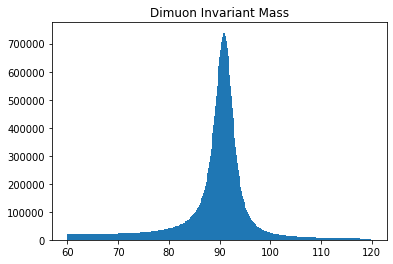

# More to try
If you have time, try the following:
* Manually implement "isolation" by requiring a dR between jets and muons
* Plot additional kinematic variables (not just the inv. mass)